# Classification. Linear models and KNN

In [108]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [109]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFECV, SequentialFeatureSelector

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [110]:
PATH = "./data/"

In [111]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')
data_test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')

In [112]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

Total passengers count: 891
Males count: 314
Females count: 577


Survived males count: 109
Survived females count: 233


Survived males in males percentage: 34.71337579617834
Survived females in females percentage: 40.38128249566724
Survived males in total passengers percentage: 12.2334455667789
Survived females in total passengers percentage: 26.15039281705948


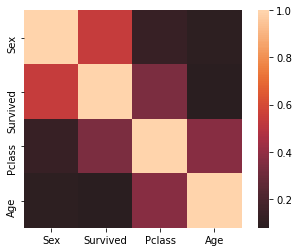

In [113]:
male, female = data.groupby("Sex")["Sex"].count()
total = male + female

# Totals
print(f"Total passengers count: {total}")
print(f"Males count: {male}")
print(f"Females count: {female}")
print('\n')

# Survived
survived_female, survived_male = data[data["Survived"] == 1].groupby("Sex")["Sex"].count()
print(f"Survived males count: {survived_male}")
print(f"Survived females count: {survived_female}")
print('\n')

# Percentages
print(f"Survived males in males percentage: {survived_male / male * 100}")
print(f"Survived females in females percentage: {survived_female / female * 100}")
print(f"Survived males in total passengers percentage: {survived_male / total * 100}")
print(f"Survived females in total passengers percentage: {survived_female / total * 100}")

# Correlation matrix
correlation = data.replace(['female','male'],[0,1])  
correlation = correlation[["Sex", "Survived", "Pclass", "Age"]].corr(method='pearson').abs()
sns.heatmap(correlation, center=0, square=True)
plt.show()

Well, actually it's difficult to say if there is any relationship between the gender and the survival because about 40% of people for each gender are survived. There are more females in the dataset from the beginning, so calculating percentage from total count of passengers is not correct. Anyway, there are more females among survived and percentage of survived females among females.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

Mean age for survived passangers: 28.343689655172415
Median age for survived passangers: 28.0


Mean age for deceased passangers: 30.62617924528302
Median age for deceased passangers: 28.0


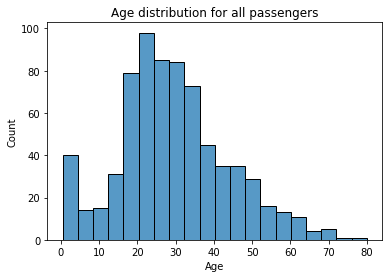

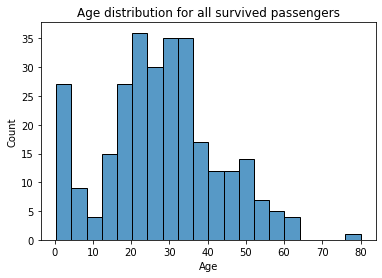

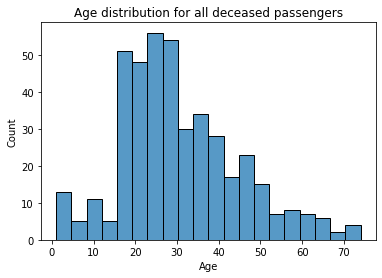

In [114]:
data_copy = data.copy()
age = data_copy["Age"]
age.dropna(inplace=True)

survived = data_copy[data_copy["Survived"] == 1]
deceased = data_copy[data_copy["Survived"] == 0]

mean = survived["Age"].mean()
median = survived["Age"].median()
print(f"Mean age for survived passangers: {mean}")
print(f"Median age for survived passangers: {median}")
print('\n')

mean = deceased["Age"].mean()
median = deceased["Age"].median()
print(f"Mean age for deceased passangers: {mean}")
print(f"Median age for deceased passangers: {median}")


sns.histplot(age, bins=20).set_title("Age distribution for all passengers")
plt.show();
sns.histplot(survived["Age"], bins=20).set_title("Age distribution for all survived passengers")
plt.show();
sns.histplot(deceased["Age"], bins=20).set_title("Age distribution for all deceased passengers")
plt.show();

Actually age distribution for survived and deceased passengers differ, there are more children among survived passengers. In other cases it's pretty similar. It's tough to say why it is but I think that parents did the best to rescue their children and it was the first prioroty for rescue operation. 

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

Passenger classes for survived passengers
Pclass
1    136
2     87
3    119
Name: Pclass, dtype: int64




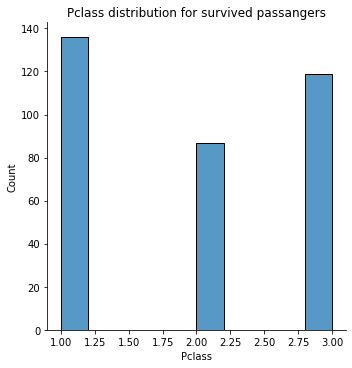

Passenger classes for deceased passengers
Pclass
1     80
2     97
3    372
Name: Pclass, dtype: int64




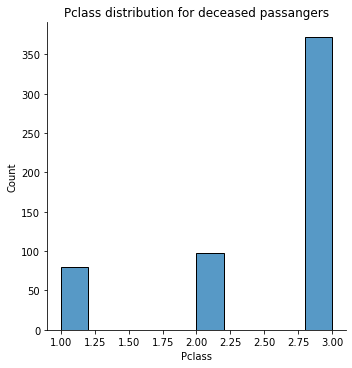

Embarked for survived passengers
Embarked
C     93
Q     30
S    217
Name: Embarked, dtype: int64




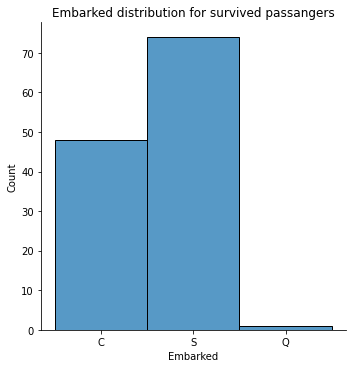

Embarked for deceased passengers
Embarked
C     75
Q     47
S    427
Name: Embarked, dtype: int64




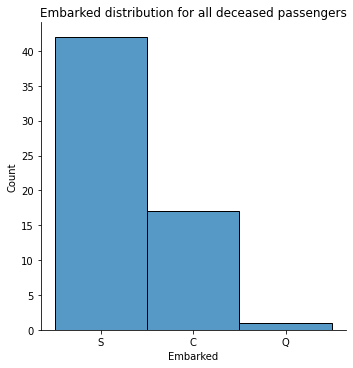

In [115]:
print("Passenger classes for survived passengers")
print(survived.groupby("Pclass")["Pclass"].count())
print('\n')

survived["Pclass"].apply(str)
deceased["Pclass"].apply(str)

sns.displot(survived, x="Pclass", bins=10)
plt.title("Pclass distribution for survived passangers")
plt.show();

print("Passenger classes for deceased passengers")
print(deceased.groupby("Pclass")["Pclass"].count())
print('\n')

sns.displot(deceased, x="Pclass", bins=10)
plt.title("Pclass distribution for deceased passangers")
plt.show();

print("Embarked for survived passengers")
print(survived.groupby("Embarked")["Embarked"].count())
print('\n')

sns.displot(survived.dropna(), x="Embarked", bins=10)
plt.title("Embarked distribution for survived passangers")
plt.show();

print("Embarked for deceased passengers")
print(deceased.groupby("Embarked")["Embarked"].count())
print('\n')

sns.displot(deceased.dropna(), x="Embarked", bins=10)
plt.title("Embarked distribution for all deceased passengers")
plt.show();

We can say that the safest class is 1 and the most dangerous is 3. Actually, we can say that S embarked is the most dangerous for passangers.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [116]:
print(f"Number of rows: {len(data)}")
print('\n')
print(f"Missed values: \n{data.isna().sum()}")
print('\n')
print(f"Missed values percentage: \n{data.isna().sum() / len(data) * 100}")

Number of rows: 891


Missed values: 
Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64


Missed values percentage: 
Survived     0.000000
Pclass       0.000000
Name         0.000000
Sex          0.000000
Age         19.865320
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.000000
Cabin       77.104377
Embarked     0.224467
dtype: float64


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?


**My thoughts**
We can drop this rows with nans, may be, drop entire columns. Also, we can fill nans with some pattern, for example, we can fill nans values for age column with mean value. Age follows normal distribution pattern so there shouldn't be any problems. Sometimes it requires to explore foreground area to find out the best solution. If we fill in nans with wrong patttern or drop important rows/columns it will affect accuracy of our model 

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [117]:
def encode_sex(df):
  return df.replace(['female','male'],[0,1])  

def process_features(feat_df):
    df = feat_df.copy()
    df.drop('Cabin', 1, inplace=True)
    df.dropna(subset=['Embarked'], inplace=True)
    df = encode_sex(df)
    df["Age"].fillna(df["Age"].mean(), inplace=True)
    return df

def get_model_accuracy(model, X, y):
    return cross_val_score(model, X, y, scoring='accuracy', cv=5).mean()

def submit(model, X, y, X_test):
    np.random.seed(333)
    model.fit(X, y)
    result = X_test.copy()
    result["Survived"] = model.predict(X_test)
    result.drop(['Age', "Sex", "Pclass"], 1, inplace=True)
    result.to_csv (r'./submission.csv', index = True, header=True)

In [118]:
# load pure data
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')
data_test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')

In [119]:
# process features
data_copied = data.copy()
feat_df = process_features(data_copied)

y = feat_df['Survived']
feat_df.drop('Survived', 1, inplace=True)


data_test_copied = data_test.copy()
feat_df_test = process_features(data_test_copied)

features = ["Age", "Pclass" , "Sex"]

best_score = 0
best_n = 0
best_features = []
for features_count in range(1, len(features) + 1):
    picked_features = features[:features_count]
    X = feat_df[picked_features]
    X_test = feat_df_test[picked_features]
    
    for n in range(1, 10):
        main_model = KNeighborsClassifier(n_neighbors=n)
        pipe_selection = make_pipeline(StandardScaler(), main_model)
        accuracy = get_model_accuracy(pipe_selection, X, y)
        if accuracy > best_score:
            best_score = accuracy
            best_n = n
            best_features = picked_features
print(f"Accuracy: {best_score}")
print(f"Neighbours count: {best_n}")
print(f"Features: {best_features}")



# main_model = KNeighborsClassifier(n_neighbors=4 | 8) # 0.8025045508756513
# pipe_selection = make_pipeline(StandardScaler(), main_model)


# main_model = KNeighborsClassifier(n_neighbors=4) # 0.8036218693114054
# pipe_selection = make_pipeline(MinMaxScaler(), main_model)
# submit(pipe_selection, X, y, X_test)




# for n in range(1, 20):
#     main_model = KNeighborsClassifier(n_neighbors=n)
#     pipe_selection = make_pipeline(StandardScaler(), main_model)
#     print('Accuracy: {:f}'.format(cross_val_score(pipe_selection, X, y, 
#                             scoring='accuracy', cv=5).mean()))


# KNN model(best)
# main_model = KNeighborsClassifier(n_neighbors=8)
# pipe_selection = make_pipeline(StandardScaler(), main_model)
# ideal = cross_val_score(pipe_selection, X, y, 
#                         scoring='accuracy', cv=5).mean()
# print('Accuracy: {:f}'.format(cross_val_score(pipe_selection, X, y, 
#                         scoring='accuracy', cv=5).mean()))




# Logistic regression model
main_model = LogisticRegression(solver='liblinear', penalty='l1', max_iter=50000)
pipe_selection = make_pipeline(StandardScaler(), main_model)
print('Accuracy: {:f}'.format(cross_val_score(pipe_selection, X, y, 
                        scoring='accuracy', cv=5).mean()))



# scaled_data_test =  sc.fit_transform(data_test)
# pipe_selection.fit(X, y)
# data_test_copied["Survived"] = pipe_selection.predict(data_test_copied)
# data_test_copied
# data_test_copied.drop(['Age', "Sex", "Pclass"], 1, inplace=True)
# data_test_copied
# # data_test.isna().sum()
# data_test_copied.to_csv (r'./sumbission.csv', index = True, header=True)



# main_model = KNeighborsClassifier(n_neighbors=4)
# pipe_selection = make_pipeline(MinMaxScaler(), main_model)

# pipe_selection.fit(X, y)
# data_test_copied["Survived"] = pipe_selection.predict(data_test_copied)
# data_test_copied.drop(['Age', "Sex", "Pclass"], 1, inplace=True)
# # data_test.isna().sum()
# data_test_copied.to_csv (r'./sumbission.csv', index = True, header=True)
# accuracy = cross_val_score(pipe_selection, X, y, 
#                         scoring='accuracy', cv=5).mean()
# print('Accuracy: {:f}'.format(accuracy))

# ideal = 0
# for n in range(1, 100):
# main_model = KNeighborsClassifier(n_neighbors=4)
# selection_model = LogisticRegression(solver='liblinear', penalty="l1", max_iter=50000)
# pipe_selection = make_pipeline(StandardScaler(), SelectFromModel(selection_model) ,main_model)
# accuracy = cross_val_score(pipe_selection, X, y, scoring='accuracy', cv=5).mean()
# if accuracy > ideal:
#     ideal = accuracy
# print(accuracy)
#  Testing
# for n in range(1, 100):
#     main_model = KNeighborsClassifier(n_neighbors=n)
#     pipe_selection = make_pipeline(MinMaxScaler(), main_model)
#     accuracy = cross_val_score(pipe_selection, X, y, 
#                             scoring='accuracy', cv=5).mean()
#     if accuracy > ideal:
#         print('Accuracy: {:f}'.format(accuracy))
#         print(n)

Accuracy: 0.8053957976258491
Neighbours count: 2
Features: ['Age', 'Pclass', 'Sex']
Accuracy: 0.786282


**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [120]:
picked_features = ['Age', 'Pclass', 'Sex']
X = feat_df[picked_features]
X_test = feat_df_test[picked_features]

Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.76 \leq score < 0.78,$$
$$ f(score) = 1.0, \ \ 0.78 \leq score < 0.81,$$ 
$$ f(score) = 2.5, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [121]:
np.random.seed(333)
main_model = KNeighborsClassifier(n_neighbors=2) # 0.8053957976258491
pipe_selection = make_pipeline(StandardScaler(), main_model)
accuracy = get_model_accuracy(pipe_selection, X, y)
print(accuracy)
submit(pipe_selection, X, y, X_test)

0.8053957976258491


This model among the others has the best train accuracy but validation accuracy is low enough. I don't remeber the exact model that I used to get the best score but I provide the screenshot with

best kaggle score: 0.77751
kaggle nickname: Deepsick
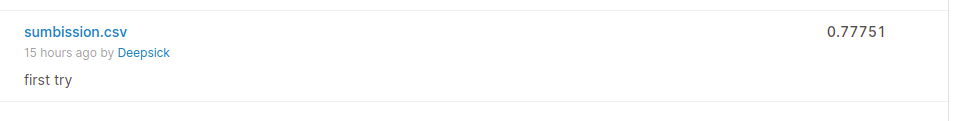
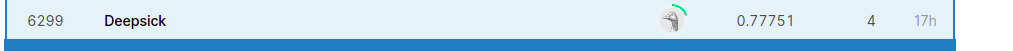